In [1]:
from dataclasses import dataclass

import numpy as np
import networkx as nx

import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from tensordict import TensorDict

from castle.datasets import DAG, IIDSimulation 
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

import causica.distributions as cd

#from causica.functional_relationships import ICGNN
from causica.functional_relationships import DECIEmbedFunctionalRelationships

from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig
from causica.graph.dag_constraint import calculate_dagness

from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import tensordict_shapes

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/home/lars/temp/causal_inference/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 14


In [4]:
# Set random seed
SEED = 11
np.random.seed(SEED)
pl.seed_everything(SEED)  

Seed set to 11


11

## DECI

### Data & configuration

In [5]:
nx.__version__

'3.4.2'

In [6]:
# Import required libraries
import networkx as nx
import numpy as np
from castle.datasets import DAG, IIDSimulation

# 🔥 Monkey-patch DAG._graph_to_adjmat to use `to_numpy_array`
def _graph_to_adjmat_patched(G):
    """Convert NetworkX graph to adjacency matrix using to_numpy_array instead of to_numpy_matrix."""
    return nx.to_numpy_array(G)  # ✅ Updated method

# Apply the fix for DAG
DAG._graph_to_adjmat = staticmethod(_graph_to_adjmat_patched)

# 🔥 Monkey-patch IIDSimulation._simulate_nonlinear_sem to use `from_numpy_array`
def _simulate_nonlinear_sem_patched(W, n, sem_type, noise_scale):
    """Patched version of `_simulate_nonlinear_sem` using `nx.from_numpy_array`."""
    d = W.shape[0]
    scale_vec = np.ones(d) if isinstance(noise_scale, (int, float)) else noise_scale
    X = np.zeros([n, d])

    B = np.tril(W, k=-1)  # Ensure acyclicity
    G_nx = nx.from_numpy_array(B, create_using=nx.DiGraph)  # ✅ FIXED: Replaced `from_numpy_matrix`
    ordered_vertices = list(nx.topological_sort(G_nx))
    assert len(ordered_vertices) == d

    # Original function logic
    for j in ordered_vertices:
        parents = np.where(W[:, j] != 0)[0]
        eta = np.random.randn(n, 1) * scale_vec[j]
        X[:, j] = np.sum(X[:, parents] * W[parents, j], axis=1) + eta.flatten()

    return X

# Apply the fix for IIDSimulation
IIDSimulation._simulate_nonlinear_sem = staticmethod(_simulate_nonlinear_sem_patched)

# ✅ Now retry generating the adjacency matrix
SEED = 42
adj_matrix = DAG.scale_free(
    n_nodes=4,
    n_edges=6,
    seed=SEED
)

# ✅ Generate the simulation
dataset = IIDSimulation(
    W=adj_matrix, 
    n=5000, 
    method='nonlinear', 
    sem_type='mim'
)

print("✅ Dataset successfully created!")


2025-02-12 15:25:30,192 - /home/lars/temp/causal_inference/lib/python3.12/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


✅ Dataset successfully created!


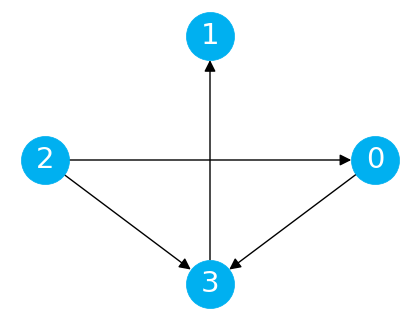

In [7]:
# Plot the graph
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(4, 3))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [9]:
# Training config
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist=cd.ContinuousNoiseDist.SPLINE
    batch_size=512
    max_epoch=500
    gumbel_temp=0.25
    averaging_period=10
    prior_sparsity_lambda=5.0
    init_rho=1.0
    init_alpha=0.0
        
training_config = TrainingConfig()
auglag_config = AugLagLRConfig()

In [10]:
# Cast data to torch tensors
data_tensors = {}

for i in range(dataset.X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(dataset.X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([dataset.X.shape[0]]))
    
# Move the entire dataset to the device (for big datasets move to device by batch within training loop)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

# Create loader
dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

dataset_train

TensorDict(
    fields={
        x0: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        x1: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        x2: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        x3: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([5000]),
    device=None,
    is_shared=False)

### Expert knowledge

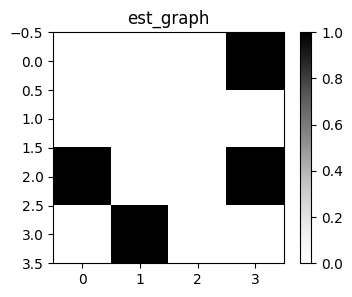

In [11]:
# Plot the true adj matrix
plt.style.use('default')
GraphDAG(adj_matrix)
plt.show()

In [12]:
# Encode our strong belief about the existence of the edge (3, 0) 
# And lack of existence of edge (0, 3)
expert_matrix = torch.tensor(np.zeros(adj_matrix.shape))

# Encode the edge knowledge
expert_matrix[3, 0] = 1.

# Create a relevancew mask
relevance_mask = expert_matrix.clone()
relevance_mask[0, 3] = 1.

# Create a confidence matrix
confidence_matrix = relevance_mask.clone()

In [13]:
# Encapsulate everything within the expert knowledge container
expert_knowledge = cd.ExpertGraphContainer(
    dag=expert_matrix,
    mask=relevance_mask,
    confidence=confidence_matrix,
    scale=5.
)

/home/lars/temp/causal_inference/lib/python3.12/site-packages/causica/distributions/adjacency/gibbs_dag_prior.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("confidence", torch.tensor(confidence, dtype=torch.float))


In [14]:
num_nodes = len(dataset_train.keys())

# Define the prior
prior = cd.GibbsDAGPrior(
    num_nodes=num_nodes, 
    sparsity_lambda=training_config.prior_sparsity_lambda,
    expert_graph_container=expert_knowledge
)

In [31]:
import torch
import causica.distributions as cd
from causica.functional_relationships import DECIEmbedFunctionalRelationships
from tensordict import TensorDict

import causica.functional_relationships

# Ensure dataset_train is valid
if not isinstance(dataset_train, TensorDict):
    raise ValueError("dataset_train is not a valid TensorDict!")

# ✅ Fix: Extract correct 1D shapes
def get_tensordict_shapes(tensordict):
    """Ensure each tensor shape is 1D."""
    return {key: torch.Size((value.shape[-1],)) for key, value in tensordict.items()}  # ✅ Extract last dim only

# ✅ Define the adjacency module
num_nodes = len(dataset_train.keys())  # Ensure num_nodes is correctly defined
adjacency_dist = cd.ENCOAdjacencyDistributionModule(num_nodes)

# ✅ Define the functional module correctly (Replacing ICGNN with DECIEmbedFunctionalRelationships)
icgnn = DECIEmbedFunctionalRelationships(
    shapes=get_tensordict_shapes(dataset_train),  # ✅ Fixed shape extraction
    embedding_size=8,  # ✅ Required argument
    out_dim_g=8,  # ✅ Required argument
    num_layers_g=2,  # ✅ Example value, change if needed
    num_layers_zeta=2  # ✅ Example value, change if needed
)

# ✅ Define the noise module
types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

# ✅ Ensure training_config.noise_dist exists
if not hasattr(training_config, "noise_dist"):
    raise ValueError("Error: `training_config.noise_dist` is not defined!")

# ✅ Create noise modules correctly
noise_submodules = cd.create_noise_modules(
    shapes=get_tensordict_shapes(dataset_train), 
    types=types_dict, 
    continuous_noise_dist=training_config.noise_dist
)

# ✅ Define the joint noise module
noise_module = cd.JointNoiseModule(noise_submodules)

print("✅ Successfully initialized adjacency, functional, and noise modules!")


✅ Successfully initialized adjacency, functional, and noise modules!


In [32]:
noise_submodules

{'x0': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x1': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x2': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x3': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 )}

In [33]:
?cd.SEMDistributionModule

Object `cd.SEMDistributionModule` not found.


In [37]:
import torch
import causica.distributions as cd
from causica.functional_relationships import DECIEmbedFunctionalRelationships
from tensordict import TensorDict

# ✅ Custom SEM Module Wrapper
class CustomSEMModule(torch.nn.Module):
    def __init__(self, adjacency_module, functional_relationships, noise_module):
        super().__init__()
        self.adjacency_module = adjacency_module
        self.functional_relationships = functional_relationships
        self.noise_module = noise_module

    def forward(self, *args, **kwargs):
        # Define how the modules interact during forward pass
        adjacency = self.adjacency_module(*args, **kwargs)
        functional_output = self.functional_relationships(adjacency)
        noise = self.noise_module(*args, **kwargs)
        return functional_output + noise  # Adjust based on how causica handles it

# ✅ Initialize the SEM module
sem_module = CustomSEMModule(
    adjacency_module=adjacency_dist,
    functional_relationships=icgnn,
    noise_module=noise_module
)

# ✅ Move to device
sem_module.to(device)

print("✅ Successfully created and moved SEM module to device!")


✅ Successfully created and moved SEM module to device!


In [40]:
modules = {
    "functional_relationships": sem_module.functional_relationships,  # ✅ Renamed from "icgnn"
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}

# ✅ Update the parameter list to use the corrected keys
parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

# ✅ Define the optimizer
optimizer = torch.optim.Adam(parameter_list)

print("✅ Successfully initialized optimizer with correct learning rates!")


✅ Successfully initialized optimizer with correct learning rates!


In [41]:
# Define the augmented Lagrangian loss objects
scheduler = AugLagLR(config=auglag_config)

auglag_loss = AugLagLossCalculator(
    init_alpha=training_config.init_alpha, 
    init_rho=training_config.init_rho
)

In [80]:
import torch
import causica.distributions as cd
from causica.functional_relationships import DECIEmbedFunctionalRelationships
from tensordict import TensorDict
import matplotlib.pyplot as plt
from causica.distributions.noise.joint import VariableTypeEnum
from causica.training.auglag import AugLagLR, AugLagLossCalculator
from causica.distributions import ENCOAdjacencyDistributionModule, JointNoiseModule, create_noise_modules

# ✅ Ensure `types_dict` uses the correct `VariableTypeEnum` values
types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

# ✅ Function to get tensor shapes
def get_tensordict_shapes(tensordict):
    """Extract the 1D shape for each tensor (last dimension only)."""
    return {key: torch.Size((value.shape[-1],)) for key, value in tensordict.items()}

# ✅ Define adjacency module
num_nodes = len(dataset_train.keys())
adjacency_dist = ENCOAdjacencyDistributionModule(num_nodes)

# ✅ Define functional module
icgnn = DECIEmbedFunctionalRelationships(
    shapes=get_tensordict_shapes(dataset_train),
    embedding_size=8,
    out_dim_g=8,
    num_layers_g=2,
    num_layers_zeta=2
)

# ✅ Ensure `training_config.noise_dist` exists
if not hasattr(training_config, "noise_dist"):
    raise ValueError("Error: `training_config.noise_dist` is not defined!")

# ✅ Create the noise modules
noise_submodules = create_noise_modules(
    shapes=get_tensordict_shapes(dataset_train),
    types=types_dict,  # ✅ Now correctly using `VariableTypeEnum.CONTINUOUS`
    continuous_noise_dist=training_config.noise_dist
)
noise_module = JointNoiseModule(noise_submodules)

# ✅ Custom SEM Module Wrapper
class CustomSEMModule(torch.nn.Module):
    def __init__(self, adjacency_module, functional_relationships, noise_module):
        super().__init__()
        self.adjacency_module = adjacency_module
        self.functional_relationships = functional_relationships
        self.noise_module = noise_module

    def forward(self, *args, **kwargs):
        # Generate the adjacency matrix (graph structure)
        adjacency = self.adjacency_module(*args, **kwargs)
        
        # Pass the adjacency matrix as the `graphs` argument to the functional relationships module
        functional_output = self.functional_relationships(graphs=adjacency)
        
        # Generate noise
        noise = self.noise_module(*args, **kwargs)
        
        # Combine functional output and noise
        return functional_output + noise  # Adjust based on how causica handles it

# ✅ Initialize the SEM module
sem_module = CustomSEMModule(
    adjacency_module=adjacency_dist,
    functional_relationships=icgnn,
    noise_module=noise_module
)

# ✅ Move to device
sem_module.to(device)

print("✅ Successfully created and moved SEM module to device!")

# Training loop
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"

num_samples = len(dataset_train)

for epoch in range(training_config.max_epoch):
    
    for i, batch in enumerate(dataloader_train):
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get SEM 
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), 
            temperature=training_config.gumbel_temp
        )  # soft sample
        
        # Compute the log probability of data
        batch_log_prob = sem.log_prob(batch).mean()
        
        # Get the distribution entropy
        sem_distribution_entropy = sem_distribution.entropy()
        
        # Compute the likelihood of the current graph
        prior_term = prior.log_prob(sem.graph)
        
        # Compute the objective
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        
        # Compute the DAG-ness term
        constraint = calculate_dagness(sem.graph)
        
        # Compute the Lagrangian loss
        loss = auglag_loss(objective, constraint / num_samples)

        # Propagate gradients and update
        loss.backward()
        optimizer.step()
        
        # Update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        
        # Log metrics & plot the matrices
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

✅ Successfully created and moved SEM module to device!


TypeError: DECIEmbedFunctionalRelationships.forward() missing 1 required positional argument: 'samples'

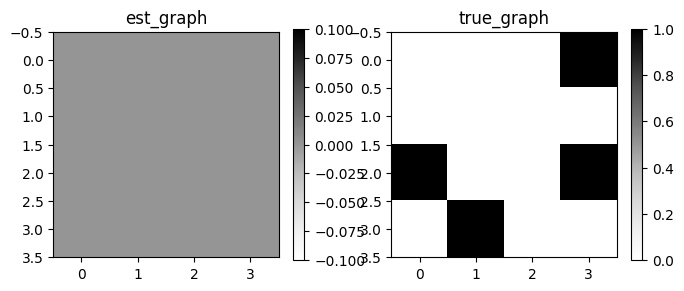

In [71]:
# Sample from the distribution of graphs
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()


# Plot the final graph vs the ground truth
plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [64]:
# Compute and print the metrics
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

metrics.metrics

{'fdr': 0.0,
 'tpr': 1.0,
 'fpr': 0.0,
 'shd': 0,
 'nnz': 4,
 'precision': 1.0,
 'recall': 1.0,
 'F1': 1.0,
 'gscore': 1.0}

## Causal discovery under hidden confounding

In [2]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge

C:\Users\aleks\anaconda3\envs\causal_book_py39_exprmnt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [22]:
# Generate confounded data
N = 1000

q = np.random.uniform(0, 2, N)
w = np.random.randn(N)
x = np.random.gumbel(0, 1, N) + w
y = 0.6 * q + 0.8 * w + np.random.uniform(0, 1, N)
z = 0.5 * x + np.random.randn(N)


data = np.stack([x, y, w, z, q]).T
confounded_data = np.stack([x, y, z, q]).T

In [23]:
# Create the true graph
nodes = ['X', 'Y', 'W', 'Z', 'Q']

edges = [
    ('W', 'X'),
    ('W', 'Y'),
    ('Q', 'Y'),
    ('X', 'Z'),
]

fci_graph = nx.DiGraph()

fci_graph.add_nodes_from(nodes)
fci_graph.add_edges_from(edges)

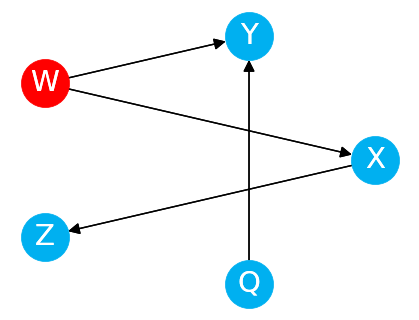

In [37]:
# Plot the graph
plt.figure(figsize=(4, 3))

nx.draw(
    G=fci_graph,
    node_color=COLORS[0],
    node_size=1200,
    nodelist=['X', 'Y', 'Z', 'Q'],
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(fci_graph)
)
nx.draw(
    G=fci_graph,
    node_color=COLORS[1],
    node_size=1200,
    nodelist=['W'],
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(fci_graph)
)

### Model 

In [39]:
# Train FCI and get the graph
g, edges = fci(
    dataset=confounded_data, 
    independence_test_method='kci'
)

Depth=1, working on node 3: 100%|████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


In [40]:
# Ordering: [x, y, z, q]
g.graph

array([[0, 2, 2, 0],
       [1, 0, 0, 1],
       [2, 0, 0, 0],
       [0, 2, 0, 0]])

In [58]:
mapping = {
    'X1': 'X',
    'X2': 'Y',
    'X3': 'Z',
    'X4': 'Q'
}

for edge in edges:
    mapped = str(edge)\
        .replace(str(edge.node1), mapping[str(edge.node1)])\
        .replace(str(edge.node2), mapping[str(edge.node2)])
    print(mapped)

X o-> Y
X o-o Z
Q o-> Y


In [51]:
str(edge), str(edge.node1)

('X1 o-> X2', 'X1')

### Model with prior knowledge

In [59]:
# Add prior knowledge
prior_knowledge = BackgroundKnowledge()
prior_knowledge.add_forbidden_by_node(GraphNode('X2'), GraphNode('X4'))
prior_knowledge.add_required_by_node(GraphNode('X1'), GraphNode('X3'))

g, edges = fci(
    dataset=confounded_data, 
    independence_test_method='fisherz',
    background_knowledge=prior_knowledge
)

Depth=1, working on node 3: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00, 471.01it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X4 --> X2
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X4 --> X2
Finishing BK Orientation.


In [60]:
for edge in edges:
    mapped = str(edge)\
        .replace(str(edge.node1), mapping[str(edge.node1)])\
        .replace(str(edge.node2), mapping[str(edge.node2)])
    print(mapped)

X o-> Y
X --> Z
Q --> Y
